In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

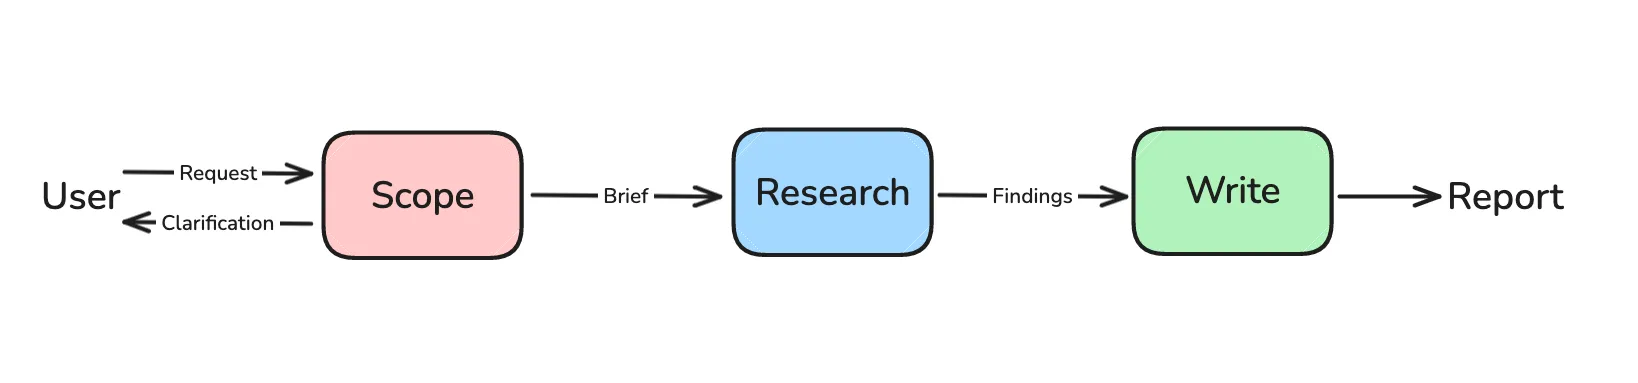

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

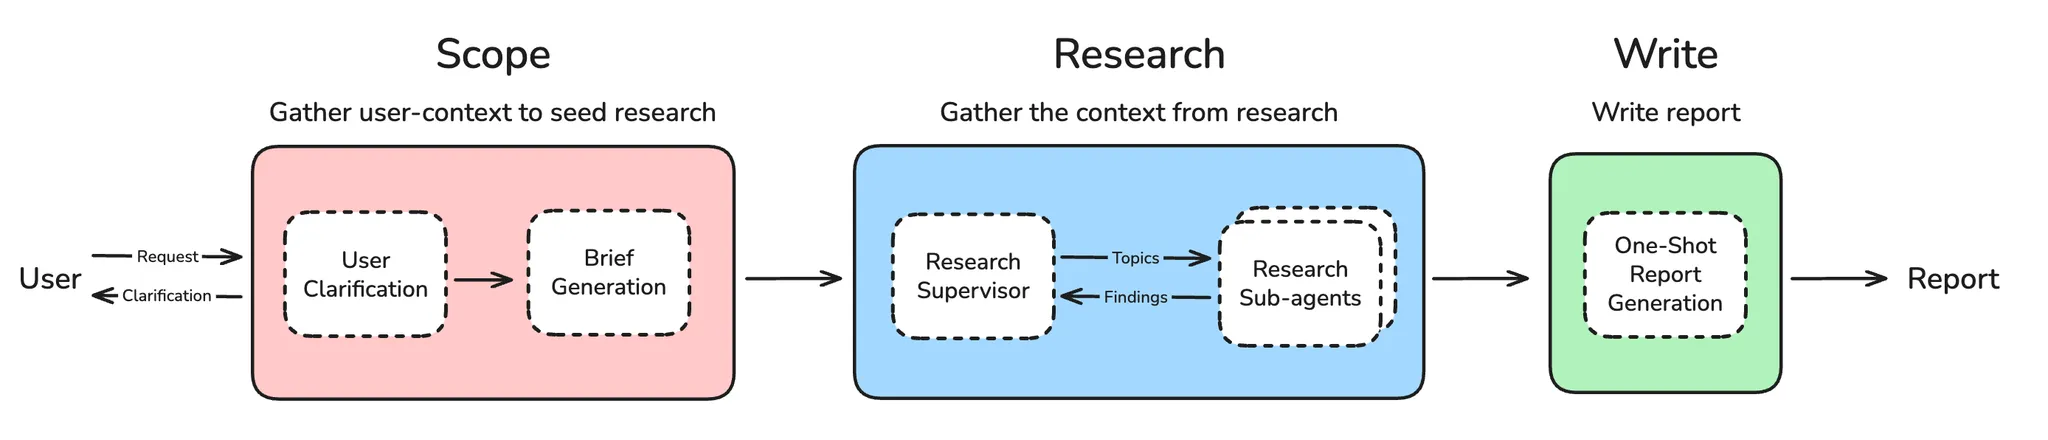

### Agent 

We simply can re-use the components we've already built.

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [3]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
# writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000
import os
from langchain_nvidia_ai_endpoints import  ChatNVIDIA
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

# supervisor_model=ChatGroq(groq_api_key=os.getenv('GROQ_API_KEY'),model='openai/gpt-oss-120b')
# writer_model=ChatNVIDIA(NVIDIA_API_KEY=os.getenv('NVIDIA_API_KEY'),model='google/gemma-2-9b-it')
writer_model = ChatGoogleGenerativeAI(
    model="models/gemini-2.5-flash",  # or "gemini-pro-vision" for images
    google_api_key=os.getenv("GOOGLE_API_KEY"),
)

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


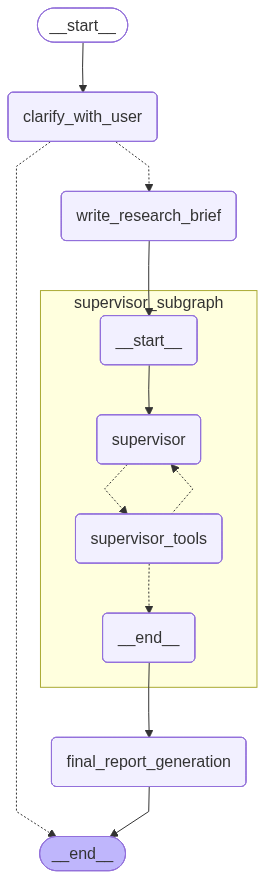

In [6]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [7]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare royal enfield classic 350 and honda cb 350")]}, config=thread)
format_messages(result['messages'])

Failed to summarize webpage: Invalid json output: Okay, let's tackle this. The user wants a summary of the webpage content provided. First, I need to figure out what the main topic is. Looking at the raw content, there's a table with Honda CB350 variants. The images at the top show the Honda logo and the CB350 model. The table lists different variants: DLX, DLX Pro, and Special Edition. Each has specifications like price, engine displacement, power, mileage, brakes, etc.

So the main purpose of the webpage is to present the specifications and pricing of different Honda CB350 motorcycle variants. It's a product page for the Honda CB350 models. The key details here are the variants, their prices, engine specs, features like transmission, brakes, weight, etc. 

Looking at the table, each row has specific data. The ex-showroom prices are given, engine displacement is 348.36 CC for all, max power is 21.07 PS @5500 rpm for all except maybe the Special Edition? Wait, no, looking at the table,

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare royal enfield classic 350 and honda cb 350                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Understood. You'd like a comparison between the Royal Enfield Classic 350 and the Honda CB 350. I will prepare  │
│ a detailed report covering specifications, performance, pricing, features, pros and cons, and overall           │
│ suitability. I will now begin the research.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: This report provides a detailed comparison between the Royal Enfield Classic 350 and  │
│ the Honda CB 350, drawing on official manufacturer sources and reputable review platforms to cover              │
│ specifications, performance metrics, pricing, features, pros and cons, and overall suitability. The analysis    │
│ considers all relevant dimensions to offer a comprehensive overview of these two popular motorcycles.           │
│                                                                                                                 │
│ ## Royal Enfield Classic 350 Overview                                                                           │
│                                                                                                                 │
│ The Royal Enfield Classic 350 is presented as a motorcycle deeply rooted in heritage and timeless aesthetics,   │
│ tracing its lineage back to the 1950 Royal Enfield G2 model [2][3]. It embodies the traditions and              │
│ craftsmanship of the past while being reborn on the modern J platform in 2021 [3]. The design is characterized  │
│ by its perfectly-proportioned silhouette, curvaceous mudguards, teardrop fuel tank, and hallmark casquette      │
│ headlamp [2][3]. The motorcycle is described as having "unwavering style" and is available in seven striking    │
│ new colorways inspired by its history [2]. It is highlighted for its blend of modern engineering and            │
│ traditional handcrafting, resulting in an "indomitable DNA" and a deep, throaty exhaust note [2]. Reviewers     │
│ note its "character styling, and quality" and "just enough power" for its segment [8].                          │
│                                                                                                                 │
│ ## Honda CB 350 Overview                                                                                        │
│                                                                                                                 │
│ The Honda CB 350, based on the research findings, is presented primarily through its technical specifications   │
│ and pricing. It features a 325.6cc OHC air-cooled 180° parallel twin engine with a bore/stroke of 64 mm × 50.6  │
│ mm [9]. Another source indicates an engine displacement of 348.36 CC [10]. The motorcycle is equipped with a    │
│ 5-speed transmission, double disc brakes, and a multiplate wet clutch [9][10]. Its kerb weight is listed as 187 │
│ kg, with a self-start only mechanism [10]. Performance figures vary across sources, with one stating 36 bhp     │
│ power, 2.55 kg·m torque, and a top speed of 110 mph (approximately 177 km/h) [9], while another lists 21.07 PS  │
│ @ 5500 rpm [10]. The research did not yield extensive details on its design philosophy or specific pros and     │
│ cons from review platforms, with one search result indicating no suggestions found for specifications and       │
│ features [11].                                                                                                  │
│                                                                                                                 │
│ ## Detailed Comparison                                                                                          │
│                                                                                                                 │
│ ### Specifications                                                                                              │
│                                                                                                                 │
│ **Engine and Performance:**                                                                                     │
│ The Royal Enfield Classic 350 is powered by a 349cc oil

In [8]:
result

{'messages': [HumanMessage(content='Compare royal enfield classic 350 and honda cb 350', additional_kwargs={}, response_metadata={}, id='bcdc1b86-8cde-46df-b0c1-97894103879b'),
  AIMessage(content="Understood. You'd like a comparison between the Royal Enfield Classic 350 and the Honda CB 350. I will prepare a detailed report covering specifications, performance, pricing, features, pros and cons, and overall suitability. I will now begin the research.", additional_kwargs={}, response_metadata={}, id='d22a47ce-b93a-4d37-b433-a9a8fbe6ba11'),
  HumanMessage(content='Here is the final report: This report provides a detailed comparison between the Royal Enfield Classic 350 and the Honda CB 350, drawing on official manufacturer sources and reputable review platforms to cover specifications, performance metrics, pricing, features, pros and cons, and overall suitability. The analysis considers all relevant dimensions to offer a comprehensive overview of these two popular motorcycles.\n\n## Roya

In [9]:
from rich.markdown import Markdown
Markdown(result["final_report"])

This report provides a detailed comparison between the Royal Enfield Classic 350 and the Honda CB 350, drawing on  
official manufacturer sources and reputable review platforms to cover specifications, performance metrics, pricing,
features, pros and cons, and overall suitability. The analysis considers all relevant dimensions to offer a        
comprehensive overview of these two popular motorcycles.                                                           


                                        Royal Enfield Classic 350 Overview                                         

The Royal Enfield Classic 350 is presented as a motorcycle deeply rooted in heritage and timeless aesthetics,      
tracing its lineage back to the 1950 Royal Enfield G2 model [2][3]. It embodies the traditions and craftsmanship of
the past while being reborn on the modern J platform in 2021 [3]. The design is characterized by its               
perfectly-proportioned silhouette, curvaceous mudguards, teardrop fuel tank, and hallmark casquette headlamp       
[2][3]. The motorcycle is described as having "unwavering style" and is available in seven striking new colorways  
inspired by its history [2]. It is highlighted for its blend of modern engineering and traditional handcrafting,   
resulting in an "indomitable DNA" and a deep, throaty exhaust note [2]. Reviewers note its "character styling, and 
quality" and "just enough power" for its segment [8].                                                              


                                               Honda CB 350 Overview                                               

The Honda CB 350, based on the research findings, is presented primarily through its technical specifications and  
pricing. It features a 325.6cc OHC air-cooled 180° parallel twin engine with a bore/stroke of 64 mm × 50.6 mm [9]. 
Another source indicates an engine displacement of 348.36 CC [10]. The motorcycle is equipped with a 5-speed       
transmission, double disc brakes, and a multiplate wet clutch [9][10]. Its kerb weight is listed as 187 kg, with a 
self-start only mechanism [10]. Performance figures vary across sources, with one stating 36 bhp power, 2.55 kg·m  
torque, and a top speed of 110 mph (approximately 177 km/h) [9], while another lists 21.07 PS @ 5500 rpm [10]. The 
research did not yield extensive details on its design philosophy or specific pros and cons from review platforms, 
with one search result indicating no suggestions found for specifications and features [11].                       


                                                Detailed Comparison                                                

                                                  Specifications                                                   

Engine and Performance: The Royal Enfield Classic 350 is powered by a 349cc oil-cooled engine, built on the new J  
platform [3][4]. While specific power and torque figures were not explicitly provided in the summaries for the     
Classic 350, reviews suggest it offers "just enough power" [8] and "effortless power and precise control" [3].     

For the Honda CB 350, the engine displacement is noted as 325.6cc OHC air-cooled 180° parallel twin [9], with      
another source specifying 348.36 CC [10]. Power figures show a notable discrepancy: one source states 36 bhp, 2.55 
kg·m torque, and a top speed of 110 mph (approximately 177 km/h) [9], while another lists 21.07 PS @ 5500 rpm [10].
It's important to note that 36 bhp is significantly higher than 21.07 PS (approximately 20.78 bhp), indicating     
different models or measurement standards, or a data inconsistency in the sources. The Honda CB 350 features a     
5-speed transmission [9][10].                                                                                      

Chassis, Brakes, and Weight: The Royal Enfield Classic 350's "signature stance" includes an upright riding position
[2]. The Redditch variant is equipped with d

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```